In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob
%matplotlib inline

## Steps for Lane Detection
* Camera Calibration
* Distortion Correction by calibration matrix and distortion coefficients
* Color and Gradient Thresholding to get binary image
* Perspective Transform into Top-down view
* Silding Window Search to find the lines
* Polyfit the get the curvature
* Transform the fit curve back to Original Image

 ### The code is mixed with some experiments

### Camera Calibration and Undistortion

In [2]:
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

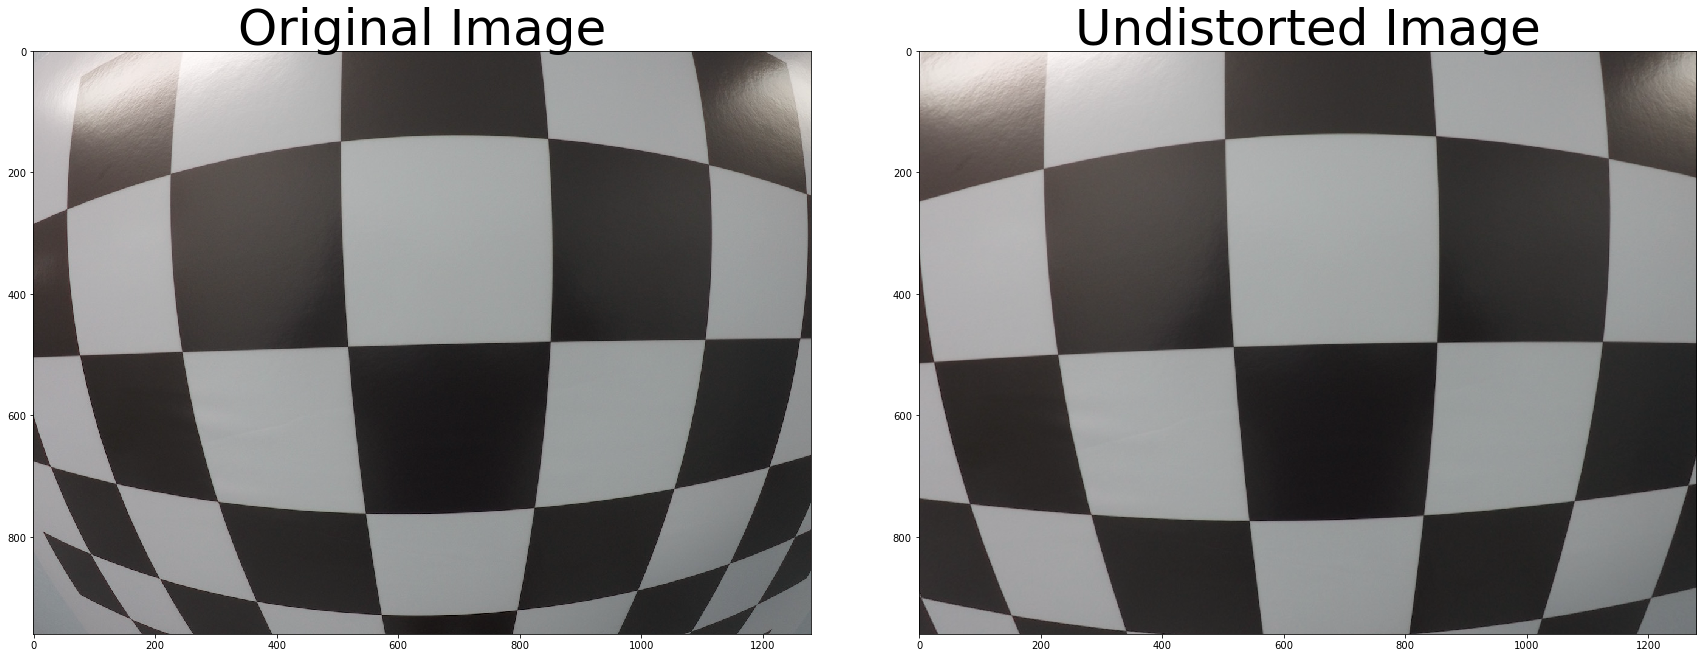

In [3]:
images = glob.glob('camera_cal/calibration*.jpg')
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y
#Since the origin corner is (0,0,0) the final corner is (nx-2,ny-2,0) relative to this corner rather than (nx-1,ny-1,0).

objpoints = []
imgpoints = []

objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

for fname in images:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
#         img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
#         plt.imshow(img)
        
img = cv2.imread('camera_cal/test_image.jpg')
# img = cv2.imread('test_images/straight_lines1.jpg')
undistorted = cal_undistort(img, objpoints, imgpoints)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Thresholding by color and gradient. The function works well because it includes x gradient, magnitude, direction, hls space.

(1440, 2560)


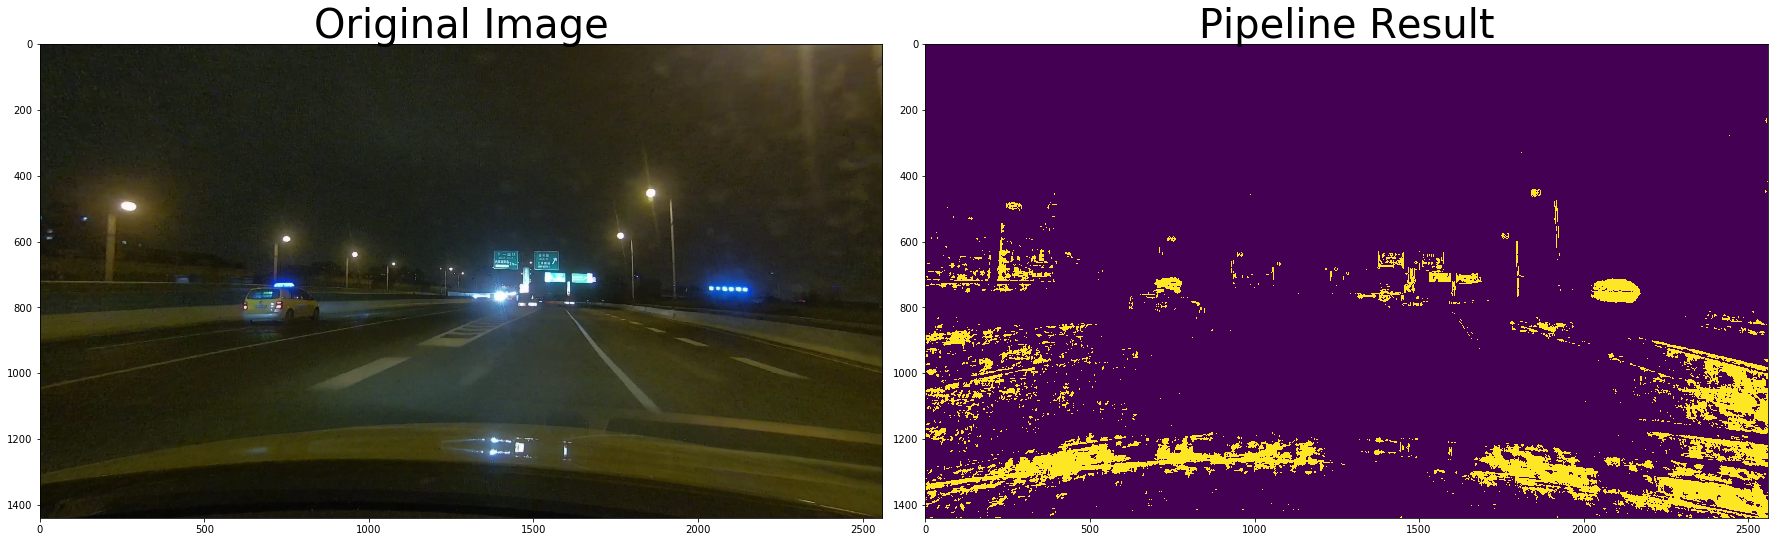

In [16]:
def abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=100):
	# Convert to grayscale
	gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
	# Apply x or y gradient with the OpenCV Sobel() function
	# and take the absolute value
	if orient == 'x':
		abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
	if orient == 'y':
		abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
	# Rescale back to 8 bit integer
	scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
	# Create a copy and apply the threshold
	binary_output = np.zeros_like(scaled_sobel)
	# Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
	binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

	# Return the result
	return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 100)):
	# Convert to grayscale
	gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
	# Take both Sobel x and y gradients
	sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
	sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
	# Calculate the gradient magnitude
	gradmag = np.sqrt(sobelx**2 + sobely**2)
	# Rescale to 8 bit
	scale_factor = np.max(gradmag)/255
	gradmag = (gradmag/scale_factor).astype(np.uint8)
	# Create a binary image of ones where threshold is met, zeros otherwise
	binary_output = np.zeros_like(gradmag)
	binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

	# Return the binary image
	return binary_output


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
	# Convert to grayscale
	gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
	# Calculate the x and y gradients
	sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
	sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
	# Take the absolute value of the gradient direction,
	# apply a threshold, and create a binary image result
	absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
	binary_output =  np.zeros_like(absgraddir)
	binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

	# Return the binary image
	return binary_output


def hls_thresh(img, thresh=(100, 255)):
	hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
	s_channel = hls[:,:,2]
	binary_output = np.zeros_like(s_channel)
	binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
	return binary_output


def combined_thresh(img):
    abs_bin = abs_sobel_thresh(img, orient='x', thresh_min=50, thresh_max=255)
    mag_bin = mag_thresh(img, sobel_kernel=3, mag_thresh=(50, 255))
    dir_bin = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
    hls_bin = hls_thresh(img, thresh=(170, 255))

    combined = np.zeros_like(dir_bin)
    combined[(abs_bin == 1 | ((mag_bin == 1) & (dir_bin == 1))) | hls_bin == 1] = 1

    return combined

image = mpimg.imread('test_images/test2.jpg')
image = cv2.imread('test_images/3.jpg')
image = mpimg.imread('test_images/4.jpg')

#image = mpimg.imread('test_images/straight_lines1.jpg')
result = combined_thresh(image)
print(result.shape)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### This is also thresholding function. Combined_thresh() is better. Skip this

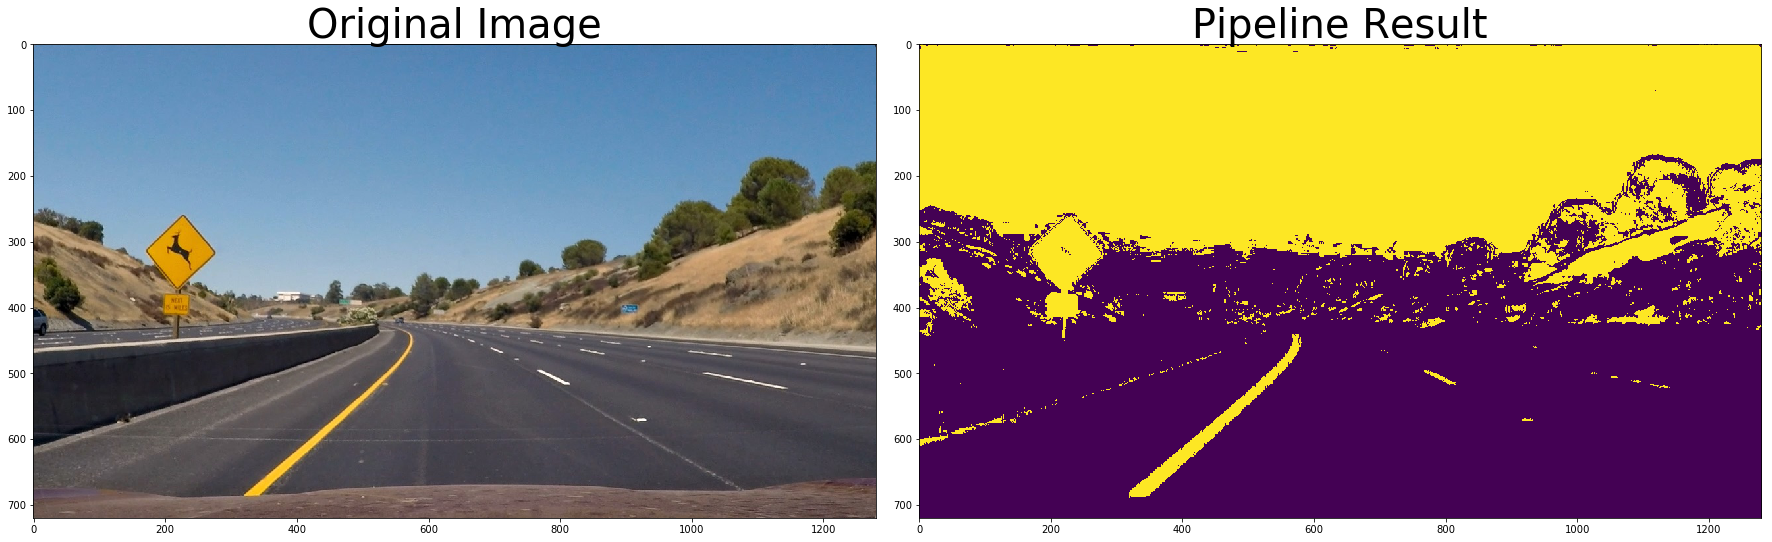

In [5]:

# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(90, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    #hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    #hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))  
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    color_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary

image = mpimg.imread('test_images/test2.jpg')
#image = mpimg.imread('test_images/straight_lines1.jpg')
result = pipeline(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Perspective Transform

In [18]:
# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def corners_unwarp(img, nx, ny, mtx, dist):
#     # Use the OpenCV undistort() function to remove distortion
#     undist = cv2.undistort(img, mtx, dist, None, mtx)
#     # Convert undistorted image to grayscale
#     gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
#     # Search for corners in the grayscaled image
#     ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
#     if ret == True:
#         # If we found corners, draw them! (just for fun)
#         cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
#         # Choose offset from image corners to plot detected corners
#         # This should be chosen to present the result at the proper aspect ratio
#         # My choice of 100 pixels is not exact, but close enough for our purpose here
#         offset = 100 # offset for dst points
#         # Grab the image shape
#         img_size = (gray.shape[1], gray.shape[0])

#         # For source points I'm grabbing the outer four detected corners
#         src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
#         # For destination points, I'm arbitrarily choosing some points to be
#         # a nice fit for displaying our warped result 
#         # again, not exact, but close enough for our purposes
#         dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
#                                      [img_size[0]-offset, img_size[1]-offset], 
#                                      [offset, img_size[1]-offset]])
#         # Given src and dst points, calculate the perspective transform matrix
#         M = cv2.getPerspectiveTransform(src, dst)
#         # Warp the image using OpenCV warpPerspective()
#         warped = cv2.warpPerspective(undist, M, img_size)

    offset = 100 # offset for dst points
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([[ 2*offset, img_size[1]], [img_size[0]-offset, img_size[1]], 
                                 [2*offset, img_size[1]//2], 
                                 [img_size[0]-2*offset, img_size[1]//2]])

    dst = np.float32([[3*offset, img_size[1]], [img_size[0]-3*offset, img_size[1]], 
                                 [3*offset, 0], 
                                 [img_size[0]-3*offset, 0]])
#     src = np.float32(
#     [[200, 720],
#     [1100, 720],
#     [595, 450],
#     [685, 450]])
#     dst = np.float32(
#     [[300, 720],
#     [980, 720],
#     [300, 0],
#     [980, 0]])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)
    
    return warped, M, Minv

In [19]:
def camera_calibration():
    images = glob.glob('camera_cal/calibration*.jpg')
    nx = 9 # the number of inside corners in x
    ny = 6 # the number of inside corners in y
    #Since the origin corner is (0,0,0) the final corner is (nx-2,ny-2,0) relative to this corner rather than (nx-1,ny-1,0).

    objpoints = []
    imgpoints = []

    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    for fname in images:
        img = mpimg.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    save_dict = {'mtx': mtx, 'dist': dist}
#     with open('calibrate_camera.p', 'wb') as f:
#         pickle.dump(save_dict, f)
    return mtx, dist

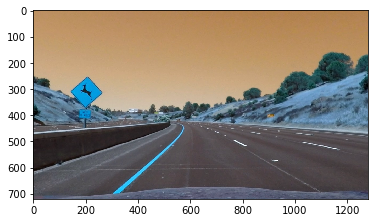

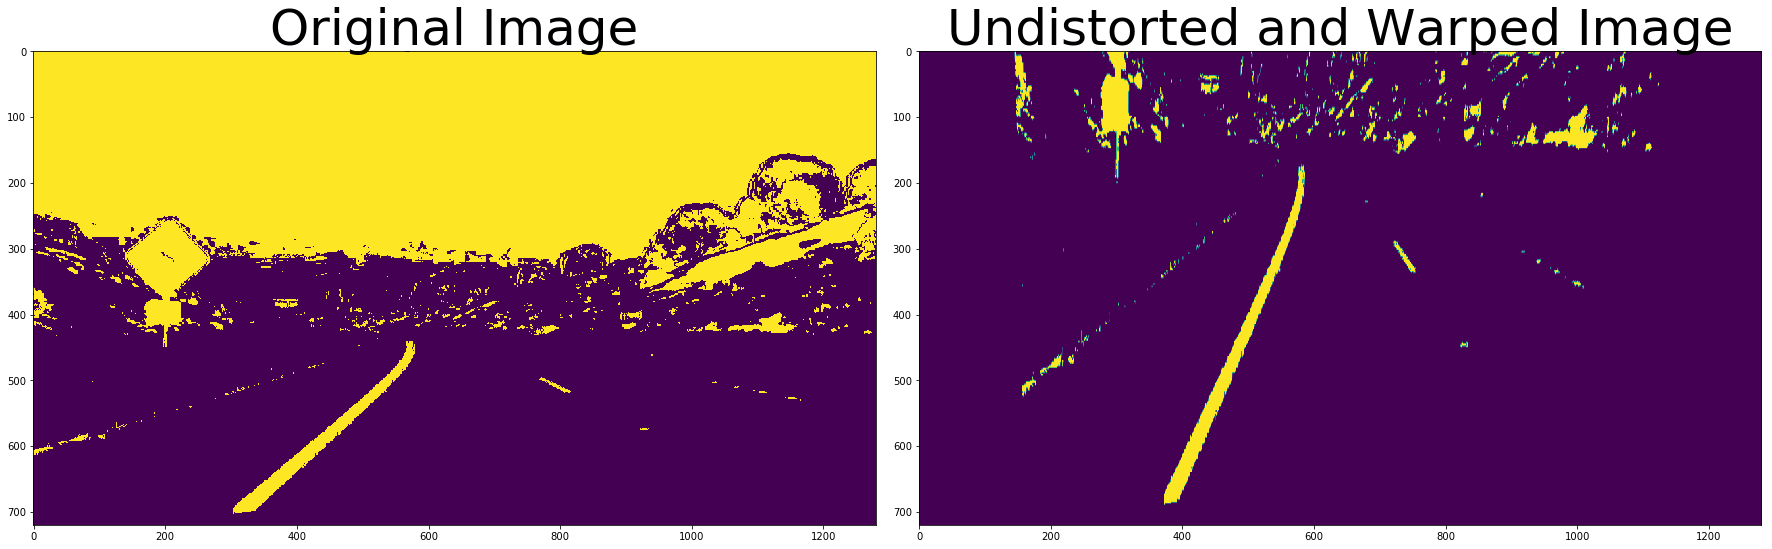

In [20]:
img = cv2.imread('test_images/test2.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
# save_dict = {'mtx': mtx, 'dist': dist}
# with open('calibrate_camera.p', 'wb') as f:
#     pickle.dump(save_dict, f)

undist = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(undist)
binary_image = np.float32(pipeline(undist)) #convert 64 to float 32
top_down, perspective_M, Minv = corners_unwarp(binary_image, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(binary_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Another window search algorithm, skip that

In [17]:
# #Convolution sliding window search
# # Read in a thresholded image
# #warped = mpimg.imread('warped_example.jpg')
# warped = np.uint8(top_down)
# warped = warped[:,:,0]
# # window settings
# window_width = 50 
# window_height = 80 # Break image into 9 vertical layers since image height is 720
# margin = 100 # How much to slide left and right for searching

# def window_mask(width, height, img_ref, center,level):
#     output = np.zeros_like(img_ref)
#     output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
#     return output

# def find_window_centroids(image, window_width, window_height, margin):
    
#     window_centroids = [] # Store the (left,right) window centroid positions per level
#     window = np.ones(window_width) # Create our window template that we will use for convolutions
    
#     # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
#     # and then np.convolve the vertical image slice with the window template 
    
#     # Sum quarter bottom of image to get slice, could use a different ratio
#     l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
#     l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
#     r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
#     r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
#     # Add what we found for the first layer
#     window_centroids.append((l_center,r_center))
    
#     # Go through each layer looking for max pixel locations
#     for level in range(1,(int)(warped.shape[0]/window_height)):
#         # convolve the window into the vertical slice of the image
#         image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
#         conv_signal = np.convolve(window, image_layer)
#         # Find the best left centroid by using past left center as a reference
#         # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
#         offset = window_width/2
#         l_min_index = int(max(l_center+offset-margin,0))
#         l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
#         l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
#         # Find the best right centroid by using past right center as a reference
#         r_min_index = int(max(r_center+offset-margin,0))
#         r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
#         r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
#         # Add what we found for that layer
#         window_centroids.append((l_center,r_center))

#     return window_centroids

# window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# # If we found any window centers
# if len(window_centroids) > 0:

#     # Points used to draw all the left and right windows
#     l_points = np.zeros_like(warped)
#     r_points = np.zeros_like(warped)

#     # Go through each level and draw the windows
#     for level in range(0,len(window_centroids)):
#         # Window_mask is a function to draw window areas
#         l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
#         r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
#         # Add graphic points from window mask here to total pixels found 
#         l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
#         r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

#     # Draw the results
#     template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
#     zero_channel = np.zeros_like(template) # create a zero color channel
#     template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
#     warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
#     output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
# # If no window centers found, just display orginal road image
# else:
#     output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# # Display the final results
# plt.imshow(output)
# plt.title('window fitting results')
# plt.show()

### Sliding Window Search

(720, 0)

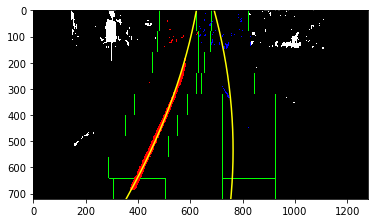

In [24]:
# Assuming you have created a warped binary image called "binary_warped"
binary_warped = np.uint8(top_down)
# binary_warped = binary_warped[:,:,0]
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [25]:
# # Generate some fake data to represent lane-line pixels
# ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
# quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# # For each y position generate random x position within +/-50 pix
# # of the line base position in each case (x=200 for left, and x=900 for right)
# leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
#                               for y in ploty])
# rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
#                                 for y in ploty])

# leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
# rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# # Fit a second order polynomial to pixel positions in each fake lane line
# left_fit = np.polyfit(ploty, leftx, 2)
# left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
# right_fit = np.polyfit(ploty, rightx, 2)
# right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# # Plot up the fake data
# mark_size = 3
# plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
# plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
# plt.xlim(0, 1280)
# plt.ylim(0, 720)
# plt.plot(left_fitx, ploty, color='green', linewidth=3)
# plt.plot(right_fitx, ploty, color='green', linewidth=3)
# plt.gca().invert_yaxis() # to visualize as we do the images

# # Define y-value where we want radius of curvature
# # I'll choose the maximum y-value, corresponding to the bottom of the image
# y_eval = np.max(ploty)
# left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
# right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
# print(left_curverad, right_curverad)

# # Define conversions in x and y from pixels space to meters
# ym_per_pix = 30/720 # meters per pixel in y dimension
# xm_per_pix = 3.7/700 # meters per pixel in x dimension

# # Fit new polynomials to x,y in world space
# left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
# right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# # Calculate the new radii of curvature
# left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
# right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# # Now our radius of curvature is in meters
# print(left_curverad, 'm', right_curverad, 'm')
# # Example values: 632.1 m    626.2 m

### Fit the curve, draw lines, transform to real space, 

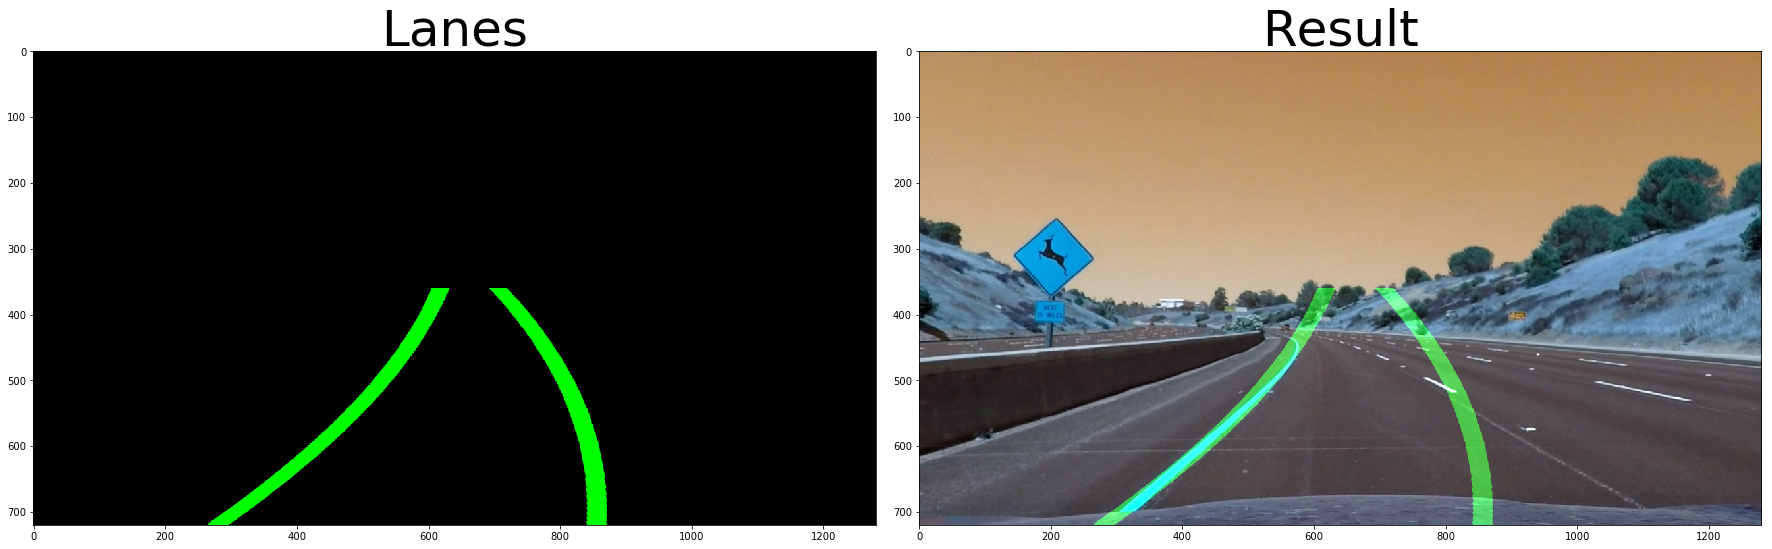

In [26]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# cv2.polylines(color_warp, np.int_([pts]),False,(0,255,0), 20)
cv2.polylines(color_warp, np.int_([pts_left]),False,(0,255,0), 20)
cv2.polylines(color_warp, np.int_([pts_right]),False,(0,255,0), 20)

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
#plt.imshow(newwarp)
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.5, 0)
#plt.imshow(result)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(newwarp)
ax1.set_title('Lanes', fontsize=50)
ax2.imshow(result)
ax2.set_title('Result', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Fill the lane; this is not we want, just for fun. 

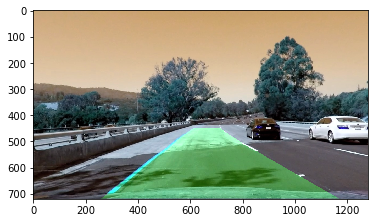

In [93]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
plt.imshow(result)

In [187]:
def combined_thresh(img):
    def abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=100):
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Apply x or y gradient with the OpenCV Sobel() function
        # and take the absolute value
        if orient == 'x':
            abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
        if orient == 'y':
            abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
        # Rescale back to 8 bit integer
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
        # Create a copy and apply the threshold
        binary_output = np.zeros_like(scaled_sobel)
        # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
        binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

        # Return the result
        return binary_output

    def mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 100)):
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Take both Sobel x and y gradients
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        # Calculate the gradient magnitude
        gradmag = np.sqrt(sobelx**2 + sobely**2)
        # Rescale to 8 bit
        scale_factor = np.max(gradmag)/255
        gradmag = (gradmag/scale_factor).astype(np.uint8)
        # Create a binary image of ones where threshold is met, zeros otherwise
        binary_output = np.zeros_like(gradmag)
        binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

        # Return the binary image
        return binary_output

    def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Calculate the x and y gradients
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        # Take the absolute value of the gradient direction,
        # apply a threshold, and create a binary image result
        absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
        binary_output =  np.zeros_like(absgraddir)
        binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

        # Return the binary image
        return binary_output

    def hls_thresh(img, thresh=(100, 255)):
        hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        s_channel = hls[:,:,2]
        binary_output = np.zeros_like(s_channel)
        binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
        return binary_output

    abs_bin = abs_sobel_thresh(img, orient='x', thresh_min=50, thresh_max=255)
    mag_bin = mag_thresh(img, sobel_kernel=3, mag_thresh=(50, 255))
    dir_bin = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
    hls_bin = hls_thresh(img, thresh=(170, 255))
    combined = np.zeros_like(hls_bin)
    combined[(abs_bin == 1 | ((mag_bin == 1) & (dir_bin == 1))) | hls_bin == 1] = 1
    return combined

## Here are all functions

In [49]:
def camera_calibration():
    images = glob.glob('camera_cal/calibration*.jpg')
    nx = 9 # the number of inside corners in x
    ny = 6 # the number of inside corners in y
    #Since the origin corner is (0,0,0) the final corner is (nx-2,ny-2,0) relative to this corner rather than (nx-1,ny-1,0).

    objpoints = []
    imgpoints = []

    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    for fname in images:
        img = mpimg.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    save_dict = {'mtx': mtx, 'dist': dist}
#     with open('calibrate_camera.p', 'wb') as f:
#         pickle.dump(save_dict, f)
    return mtx, dist

def undistort_image(img, mtx, dist):
    # Use cv2.calibrateCamera() and cv2.undistort()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

def perspective_transform(img, mtx, dist):
    #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = img
    offset = 100 # offset for dst points
    # Grab the image shape
    img_size = (gray.shape[1], gray.shape[0])

    src = np.float32([[ 2*offset, img_size[1]], [img_size[0]-2*offset, img_size[1]], 
                                 [img_size[0]//2-offset, img_size[1]//2+offset], 
                                 [img_size[0]//2+offset, img_size[1]//2+offset]])

    dst = np.float32([[3*offset, img_size[1]], [img_size[0]-3*offset, img_size[1]], 
                                 [3*offset, 0], 
                                 [img_size[0]-3*offset, 0]])
#     src = np.float32(
#     [[200, 720],
#     [1100, 720],
#     [595, 450],
#     [685, 450]])
#     dst = np.float32(
#     [[300, 720],
#     [980, 720],
#     [300, 0],
#     [980, 0]])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)
    #warped = np.uint8(warped[:,:,0])
    warped = np.uint8(warped)
    return warped, M, Minv

def line_search(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return left_fit, right_fit

def draw_line(undist, warped, Minv, left_fit, right_fit):
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.polylines(color_warp, np.int_([pts_left]),False,(0,255,0), 20)
    cv2.polylines(color_warp, np.int_([pts_right]),False,(0,255,0), 20)
#     cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    #plt.imshow(newwarp)
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.5, 0)
    #plt.imshow(result)

    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    f.tight_layout()
    ax1.imshow(undist)
    ax1.set_title('Oringinal', fontsize=50)
    ax2.imshow(newwarp)
    ax2.set_title('Lanes', fontsize=50)
    ax3.imshow(result)
    ax3.set_title('Result', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

def lane_detect(img, mtx, dist):
    undist = undistort_image(img, mtx, dist)
    binary_image = combined_thresh(undist)
    top_down, transform_M, Minv = perspective_transform(binary_image, mtx, dist)
    left_fit, right_fit = line_search(top_down)
    draw_line(undist, top_down, Minv, left_fit, right_fit)
    

In [35]:
mtx, dist = camera_calibration()

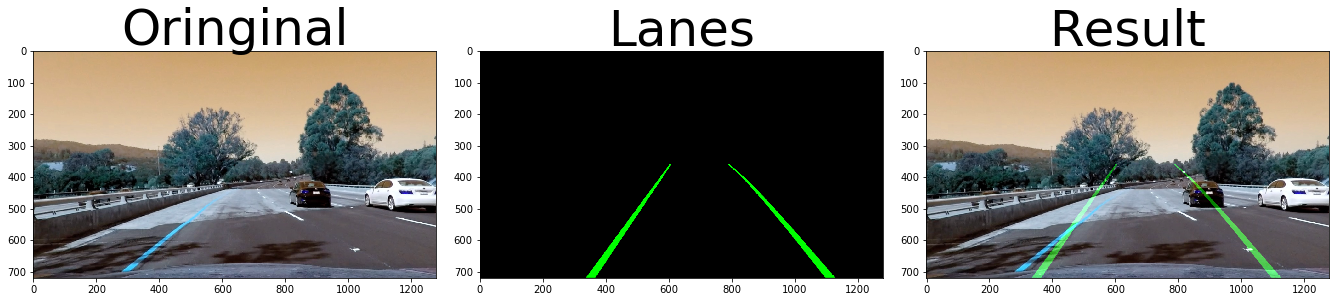

In [50]:
img = cv2.imread('test_images/test4.jpg')
lane_detect(img, mtx, dist)

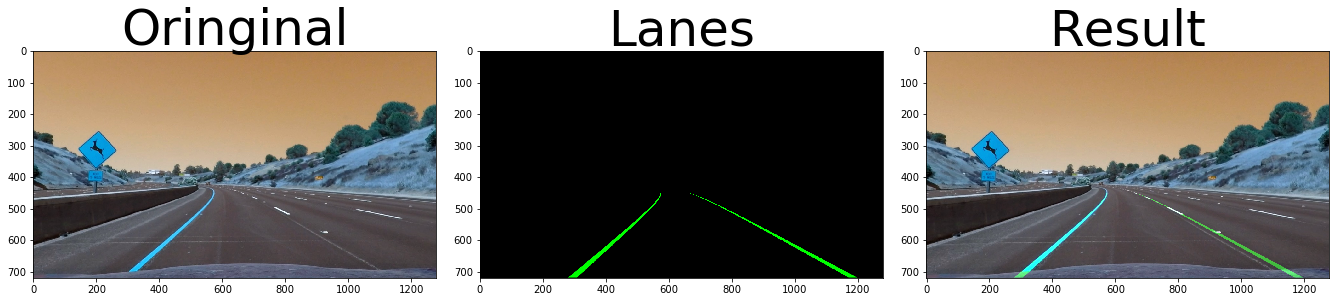

In [40]:
img = cv2.imread('test_images/test2.jpg')
lane_detect(img, mtx, dist)

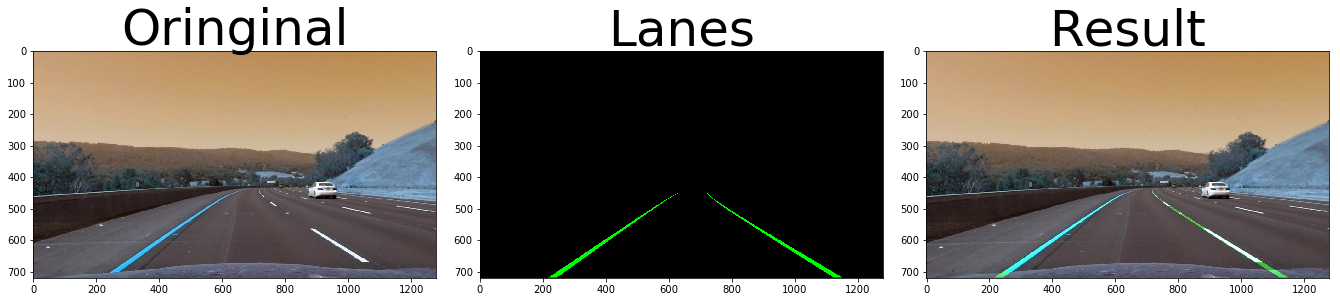

In [43]:
img = cv2.imread('test_images/test3.jpg')
lane_detect(img, mtx, dist)

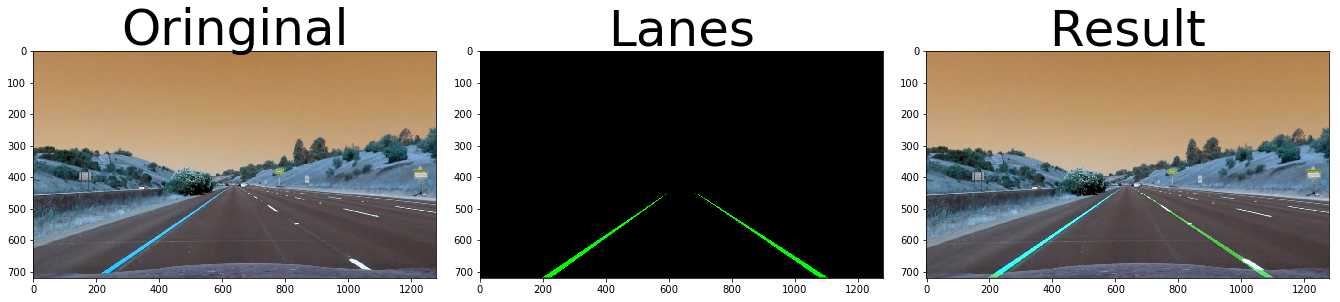

In [207]:
img = cv2.imread('test_images/straight_lines1.jpg')
lane_detect(img, mtx, dist)

## Without Calibration

In [11]:
def combined_thresh(img):
    def abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=100):
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Apply x or y gradient with the OpenCV Sobel() function
        # and take the absolute value
        if orient == 'x':
            abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
        if orient == 'y':
            abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
        # Rescale back to 8 bit integer
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
        # Create a copy and apply the threshold
        binary_output = np.zeros_like(scaled_sobel)
        # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
        binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

        # Return the result
        return binary_output

    def mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 100)):
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Take both Sobel x and y gradients
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        # Calculate the gradient magnitude
        gradmag = np.sqrt(sobelx**2 + sobely**2)
        # Rescale to 8 bit
        scale_factor = np.max(gradmag)/255
        gradmag = (gradmag/scale_factor).astype(np.uint8)
        # Create a binary image of ones where threshold is met, zeros otherwise
        binary_output = np.zeros_like(gradmag)
        binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

        # Return the binary image
        return binary_output

    def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Calculate the x and y gradients
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        # Take the absolute value of the gradient direction,
        # apply a threshold, and create a binary image result
        absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
        binary_output =  np.zeros_like(absgraddir)
        binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

        # Return the binary image
        return binary_output

    def hls_thresh(img, thresh=(100, 255)):
        hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        s_channel = hls[:,:,2]
        binary_output = np.zeros_like(s_channel)
        binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
        return binary_output

    abs_bin = abs_sobel_thresh(img, orient='x', thresh_min=50, thresh_max=255)
    mag_bin = mag_thresh(img, sobel_kernel=3, mag_thresh=(50, 255))
    dir_bin = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
    hls_bin = hls_thresh(img, thresh=(170, 255))
    combined = np.zeros_like(hls_bin)
    combined[(abs_bin == 1 | ((mag_bin == 1) & (dir_bin == 1))) | hls_bin == 1] = 1
    return combined

def perspective_transform(img):
    #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = img
    offset = 100 # offset for dst points
    # Grab the image shape
    img_size = (gray.shape[1], gray.shape[0])

    src = np.float32([[ 2*offset, img_size[1]], [img_size[0]-2*offset, img_size[1]], 
                                 [img_size[0]//2-offset, img_size[1]//2+offset], 
                                 [img_size[0]//2+offset, img_size[1]//2+offset]])

    dst = np.float32([[3*offset, img_size[1]], [img_size[0]-3*offset, img_size[1]], 
                                 [3*offset, 0], 
                                 [img_size[0]-3*offset, 0]])
    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)
    #warped = np.uint8(warped[:,:,0])
    warped = np.uint8(warped)
    return warped, M, Minv

def line_search(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return left_fit, right_fit

def draw_line(undist, warped, Minv, left_fit, right_fit):
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.polylines(color_warp, np.int_([pts_left]),False,(0,255,0), 20)
    cv2.polylines(color_warp, np.int_([pts_right]),False,(0,255,0), 20)
#     cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    #plt.imshow(newwarp)
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.5, 0)
    #plt.imshow(result)

    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    f.tight_layout()
    ax1.imshow(undist)
    ax1.set_title('Oringinal', fontsize=50)
    ax2.imshow(newwarp)
    ax2.set_title('Lanes', fontsize=50)
    ax3.imshow(result)
    ax3.set_title('Result', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

def lane_detect(img):
    binary_image = combined_thresh(img)
    top_down, transform_M, Minv = perspective_transform(binary_image)
    left_fit, right_fit = line_search(top_down)
    draw_line(img, top_down, Minv, left_fit, right_fit)

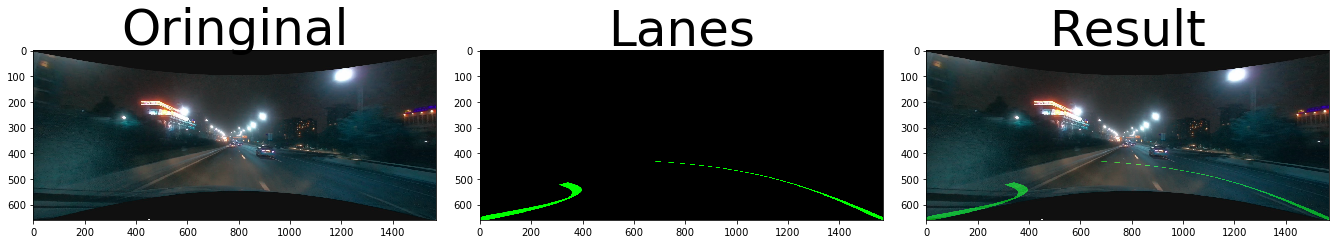

In [12]:
img = cv2.imread('test_images/3.jpg')
lane_detect(img)

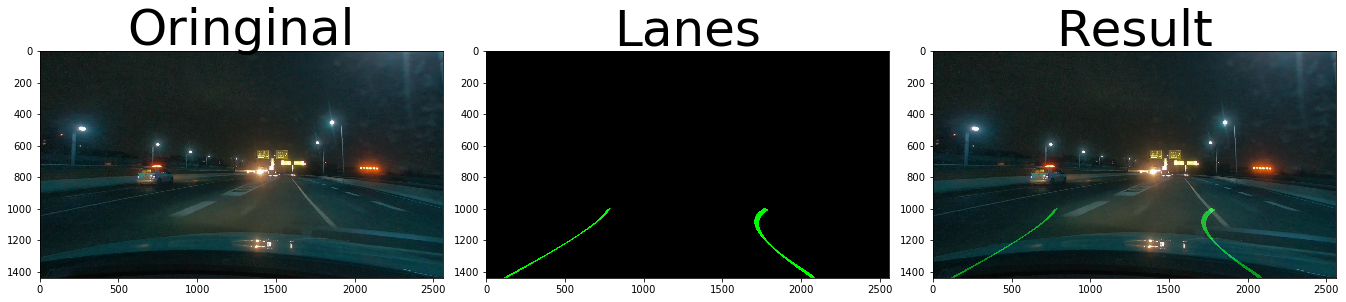

In [13]:
img = cv2.imread('test_images/4.jpg')
lane_detect(img)